In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Đọc và chuẩn bị dữ liệu
df = pd.read_csv('SAMSUNG.csv', header=0, parse_dates=[0], index_col=0)
df = df[['Price']]
df = df.dropna()
df = df.reset_index(drop=True)

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.7)
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [3]:
# Initialize the list to store predictions from all models
predictions_all = []  # Add this line to initialize the list

In [4]:
# Xây dựng các mô hình LSTM với Boosting
num_models = 5  # Số lượng mô hình cần huấn luyện
models = []
# Xây dựng mô hình LSTM với Dropout
for i in range(num_models):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    if i == 0:
        model.fit(X_train, y_train, batch_size=1, epochs=1)
    else:
        # Cập nhật dữ liệu huấn luyện dựa trên lỗi của mô hình trước
        updated_y_train = y_train - predictions_all[i - 1]  # Sử dụng lỗi dự đoán làm mục tiêu
        updated_X_train = X_train
        model.fit(X_train, y_train, batch_size=1, epochs=1)
    predictions = model.predict(X_test)  # Lưu dự đoán của mỗi mô hình
    predictions_all.append(predictions)
    models.append(model)
# Kết hợp các dự đoán (ví dụ: lấy trung bình)
final_predictions = np.mean(predictions_all, axis=0)




16/16 [==============================] - 1s 19ms/step


In [5]:
# Dự đoán và chuyển ngược dữ liệu
train_predict = final_predictions  # Use the ensembled predictions
test_predict = final_predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Tính toán dự đoán cho 30 ngày tiếp theo
X_input = scaled_data[len(scaled_data) - time_step:]
X_input = X_input.reshape(1, -1)
X_input = X_input[0, :30].reshape(1, -1)
X_input = X_input.reshape((1, 30, 1))

predicted_next_30_days = []
for i in range(30):
    predicted_price = model.predict(X_input)  # Use the final model for predictions
    predicted_next_30_days.append(predicted_price[0, 0])
    X_input = np.roll(X_input, -1)
    X_input[0, -1, 0] = predicted_price

predicted_next_30_days = np.array(predicted_next_30_days)
predicted_next_30_days = predicted_next_30_days.reshape(-1, 1)
predicted_next_30_days = scaler.inverse_transform(predicted_next_30_days)




1/1 [==============================] - 0s 44ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7032\1114983912.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_input[0, -1, 0] = predicted_price


1/1 [==============================] - 0s 34ms/step


In [6]:
# Tạo chỉ số cho dữ liệu
train_index = df.index[time_step:train_size + time_step]
test_index = df.index[train_size + time_step:-1]

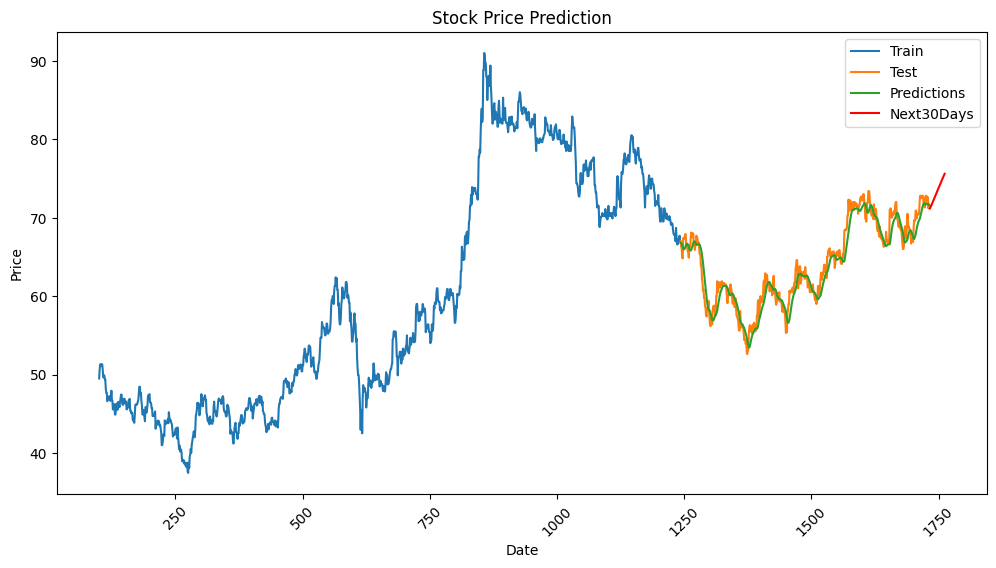

In [7]:
# Xác định ngày cuối cùng của dữ liệu kiểm tra
last_test_date = df.index[-1]
last_data = pd.RangeIndex(start=last_test_date, stop=last_test_date + 30, step=1)



# Tạo chỉ số cho dữ liệu
train_index = df.index[time_step:train_size+time_step]
test_index = df.index[train_size+time_step:-1]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_index, scaler.inverse_transform(scaled_data[time_step:train_size + time_step]), label='Train')
plt.plot(test_index, scaler.inverse_transform(scaled_data[train_size + time_step:-1]), label='Test')
plt.plot(test_index, test_predict, label='Predictions')
plt.plot(last_data, predicted_next_30_days, label='Next30Days', color='red')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

# Hiển thị
plt.show()


In [8]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error  # Import necessary metrics
# Calculate RMSE, MAPE, and MAE
test_rmse = np.sqrt(np.mean((test_predict - y_test) ** 2))
test_mape = mean_absolute_percentage_error(y_test, test_predict)
test_mae = mean_absolute_error(y_test, test_predict)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 63.51975067935817
Testing MAPE: 129.91494169338966
Testing MAE: 63.323981919224394
